In [1]:
import calendar
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def symbol_to_path(symbol, base_dir="Daily"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def normalize_data(df):
    return df/df.ix[0,:]

def get_data(symbols, dates,col):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'TASI' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'TASI')
    dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=['Date'],date_parser=dateparse, usecols=['Date', col ], na_values=['nan'])
        df_temp = df_temp.rename(columns={col: symbol})
        df = df.join(df_temp)
        if symbol == 'TASI':  # drop dates SPY did not trade
            df = df.dropna(subset=["TASI"])

    return df

def compute_daily_returns(df):
    daily_returns = (df/df.shift(1))-1 
    daily_returns = daily_returns[1:]
    # daily_returns.plot(kind="hist")
    plt.show()
    return daily_returns

def load_df():
    dates = pd.date_range('01/01/2002', '01/01/2017')
    N= (dates[-1]-dates[0])/365
    N = str(N).split()[0]
    files = os.listdir("AdjDaily")
    symbols=[]
    for name in files:
        if name[0].isdigit():
            symbols.append(name.split('.')[0])
    df = get_data(symbols, dates, 'Close')
    df.to_pickle('database.pkl')
    return df

def stats(df,period):
    if period == 'W':
        p = 52.0
    if period == 'M':
        p = 12.0
    if period == 'D':
        p = 365.0
    cagr = (df.iloc[-1]/df.iloc[0])**(1.0/(len(df)/p)) - 1.0
    dr = compute_daily_returns(df)
    sharpe = np.sqrt(p) * dr.mean() / dr.std()
    print (' CAGR(%) = ' + str(cagr * 100))
    print (' Sharpe ratio = ' + str(sharpe))

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

def pos_val(df,capital=100000,alloc=[]):
    if alloc == []:
        alloc= 1.0/len(df.columns)
    return (normalize_data(df) * alloc * capital).sum(axis=1)

In [3]:
df = pd.read_pickle('AdjustedClose.pkl')

In [4]:
adjusted = df[['AdjClose']]

In [5]:
adjusted.head()

AdjClose
Symbol Date                
1010   2001-12-31  3.201672
       2002-01-01  3.201672
       2002-01-02  3.201672
       2002-01-03  3.255378
       2002-01-05  3.255378

In [6]:
port_2006 = adjusted.xs(slice('01/01/2009','29/03/2018'),level=1,drop_level=False)

In [7]:
port_2006 = port_2006['AdjClose'].unstack(level=0)
port_2006.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-03,6.230656,7.211983,8.069639,7.979272,15.700775,16.448534,10.029139,14.685743,22.202156,10.413853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,6.202022,7.237648,8.194750,7.895632,15.857926,17.176345,9.914250,14.840738,22.202156,10.413853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,6.242109,7.306089,8.444971,7.895632,16.450812,17.467470,10.029139,15.111978,22.771118,10.487384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,6.242109,7.417306,8.914136,7.979272,17.307997,17.613032,10.272433,15.460716,23.814215,10.560915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,6.299376,7.442971,8.577901,8.021092,18.272331,18.049719,10.272433,15.848203,24.098696,10.294365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
mask = port_2006.iloc[0].isnull()
port_2006 = port_2006.loc[:,~mask]
mask = port_2006.iloc[0]==0
port_2006 = port_2006.loc[:,~mask]

In [9]:
port_2006 = port_2006 / port_2006.iloc[0]
port_2006.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8120,8130,8140,8150,8160,8170,8180,8190,8200,8210
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2009-01-04,0.995404,1.003559,1.015504,0.989518,1.010009,1.044248,0.988544,1.010554,1.000000,1.000000,...,1.068676,1.096990,1.099899,1.101695,1.037879,1.039954,1.048338,0.899304,1.075000,1.099057
2009-01-05,1.001838,1.013049,1.046512,0.989518,1.047771,1.061947,1.000000,1.029024,1.025626,1.007061,...,1.021739,1.177258,1.095526,1.057627,1.006993,1.027397,1.028701,0.855684,1.080172,1.075472
2009-01-06,1.001838,1.028470,1.104651,1.000000,1.102366,1.070796,1.024259,1.052770,1.072608,1.014122,...,1.094368,1.113712,1.153380,1.111864,1.103730,1.075342,1.066465,0.853364,1.080172,1.108491
2009-01-07,1.011029,1.032028,1.062984,1.005241,1.163785,1.097345,1.024259,1.079156,1.085421,0.988526,...,1.105237,1.056856,1.106963,1.061017,1.096737,1.067352,1.123867,0.881671,1.069828,1.082547


In [51]:
def portfolio(df):
    if isinstance(df,pd.DataFrame):
        capital = df.shape[1] * 1000
        alloc = 1 / df.shape[1]
    else:
        capital = 1000
        alloc = 1 
    postions = norm(df) * alloc * capital
    if isinstance(df,pd.DataFrame):
        portfolio = postions.sum(axis=1)
    else:
        portfolio = postions
    return portfolio

def norm(df):
    if isinstance(df,pd.DataFrame):
        mask = df.iloc[0].isnull()
        df = df.loc[:,~mask]
        mask = df.iloc[0]==0
        df = df.loc[:,~mask]
    df = df / df.iloc[0]
    return df

In [12]:
df = pd.read_pickle('normalized.pkl')

In [13]:
df.head()

Close  AdjClose
Symbol Date                          
1010   2001-12-31  1.000000  1.000000
       2002-01-01  1.000000  1.000000
       2002-01-02  1.000000  1.000000
       2002-01-03  1.016774  1.016774
       2002-01-05  1.016774  1.016774

In [22]:
close = df['Close'].xs(slice('01/01/2009','31/12/2018'),level=1,drop_level=False)

In [15]:
adjclose = df['AdjClose'].xs(slice('01/01/2009','31/12/2018'),level=1,drop_level=False)

In [23]:
close = close.unstack(level=0)
close.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-03,1.403871,3.542017,1.720000,1.5264,2.211268,2.539326,2.545455,1.280405,2.855285,0.185191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,1.397419,3.554622,1.746667,1.5104,2.233400,2.651685,2.516295,1.293919,2.855285,0.185191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,1.406452,3.588235,1.800000,1.5104,2.316901,2.696629,2.545455,1.317568,2.928455,0.186499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,1.406452,3.642857,1.900000,1.5264,2.437626,2.719101,2.607204,1.347973,3.062602,0.187806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,1.419355,3.655462,1.828333,1.5344,2.573441,2.786517,2.607204,1.381757,3.099187,0.183066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
adjclose = adjclose.unstack(level=0)
adjclose.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-03,1.946063,3.842999,1.921397,1.802936,2.606683,3.167671,2.949600,1.614576,3.545567,0.185191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,1.937120,3.856676,1.951186,1.784037,2.632774,3.307834,2.915810,1.631617,3.545567,0.185191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,1.949640,3.893145,2.010764,1.784037,2.731206,3.363899,2.949600,1.661437,3.636427,0.186499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,1.949640,3.952409,2.122473,1.802936,2.873519,3.391931,3.021153,1.699778,3.803004,0.187806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,1.967527,3.966085,2.042415,1.812385,3.033620,3.476029,3.021153,1.742379,3.848434,0.183066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
portfolio(close[4190])

Date
2009-01-03    1000.000000
2009-01-04     991.385332
2009-01-05     986.961583
2009-01-06    1013.038417
2009-01-07     982.537835
2009-01-10     947.613504
2009-01-11     938.998836
2009-01-12     921.536671
2009-01-13     912.689173
2009-01-14     904.074505
2009-01-17     869.848661
2009-01-18     882.188591
2009-01-19     886.379511
2009-01-20     886.379511
2009-01-21     882.188591
2009-01-24     904.074505
2009-01-25     921.536671
2009-01-26     921.536671
2009-01-27     952.037253
2009-01-28     938.998836
2009-01-31     934.575087
2009-02-01     930.151339
2009-02-02     917.112922
2009-02-03     938.998836
2009-02-04     947.613504
2009-02-07     969.499418
2009-02-08     956.461001
2009-02-09     952.037253
2009-02-10     956.461001
2009-02-11     943.189756
                 ...     
2018-11-20    3376.018626
2018-11-21    3380.675204
2018-11-22    3436.554133
2018-11-25    3450.523865
2018-11-26    3427.240978
2018-11-27    3464.493597
2018-11-28    3506.402794
2018-11

In [62]:
portfolio(adjclose[4190])

Date
2009-01-03    1000.000000
2009-01-04     991.385332
2009-01-05     986.961583
2009-01-06    1013.038417
2009-01-07     982.537835
2009-01-10     947.613504
2009-01-11     938.998836
2009-01-12     921.536671
2009-01-13     912.689173
2009-01-14     904.074505
2009-01-17     869.848661
2009-01-18     882.188591
2009-01-19     886.379511
2009-01-20     886.379511
2009-01-21     882.188591
2009-01-24     904.074505
2009-01-25     921.536671
2009-01-26     921.536671
2009-01-27     952.037253
2009-01-28     938.998836
2009-01-31     934.575087
2009-02-01     930.151339
2009-02-02     917.112922
2009-02-03     938.998836
2009-02-04     947.613504
2009-02-07     969.499418
2009-02-08     956.461001
2009-02-09     952.037253
2009-02-10     956.461001
2009-02-11     943.189756
                 ...     
2018-11-20    5591.773266
2018-11-21    5599.486057
2018-11-22    5784.162775
2018-11-25    5807.675632
2018-11-26    5768.487537
2018-11-27    5831.188489
2018-11-28    5901.727059
2018-11

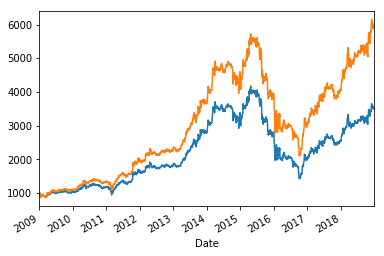

In [60]:
portfolio(close[4190]).plot()
portfolio(adjclose[4190]).plot()